In [186]:
%matplotlib notebook
import numpy as np
import scipy
from scipy import optimize
from scipy import interpolate
import matplotlib as mpl
from matplotlib import pyplot as plt
import math
from scipy.interpolate import interp1d
import warnings
warnings.simplefilter('always', DeprecationWarning)
warnings.filterwarnings('ignore')

In [187]:
# load text file MC error
data = np.loadtxt('/Users/niloo/Desktop/Lab_data/altogether/MC_error/Nov_3_interpolatedpos.txt')
Temperature = data[:,4]
J = data[:,-3]
T_low =data[:,5]
T_high = data[:,6]
J_low = data[:,-2]
J_high = data[:,-1]

In [188]:
# sort temperature values
T = sorted(Temperature)

In [189]:
# sorting values based on temperature values
sort_J = [x for _,x in sorted(zip(Temperature,J))]
sort_T_low = [x for _,x in sorted(zip(Temperature,T_low))]
sort_T_high = [x for _,x in sorted(zip(Temperature,T_high))]
sort_J_low = [x for _,x in sorted(zip(Temperature,J_low))]
sort_J_high = [x for _,x in sorted(zip(Temperature,J_high))]

In [190]:
# linear fit y= mx+b, y_intercept b = y - mx
def slope_and_intercept(xs,ys):
    m = ((np.mean(xs) * np.mean(ys)) - np.mean(xs * ys))/ ((np.mean(xs) * np.mean(xs)) - np.mean(xs * xs))
    b = np.mean(ys) - (m * np.mean(xs))
    return m,b

In [193]:
# ref. The apparent activation energy and pre-exponential kinetic factor for heterogeneous calcium carbonate nucleation on quartz
# Laksmono supplementary
T_inverse = 1./np.array(T)

In [192]:
# remove the nan and inf values from T and log_J
idx = np.where((np.isnan(np.log(sort_J))==False) & (np.isinf(np.log(sort_J))==False))
new_J = np.log(sort_J)[idx]
new_T = T_inverse[idx]

<IPython.core.display.Javascript object>


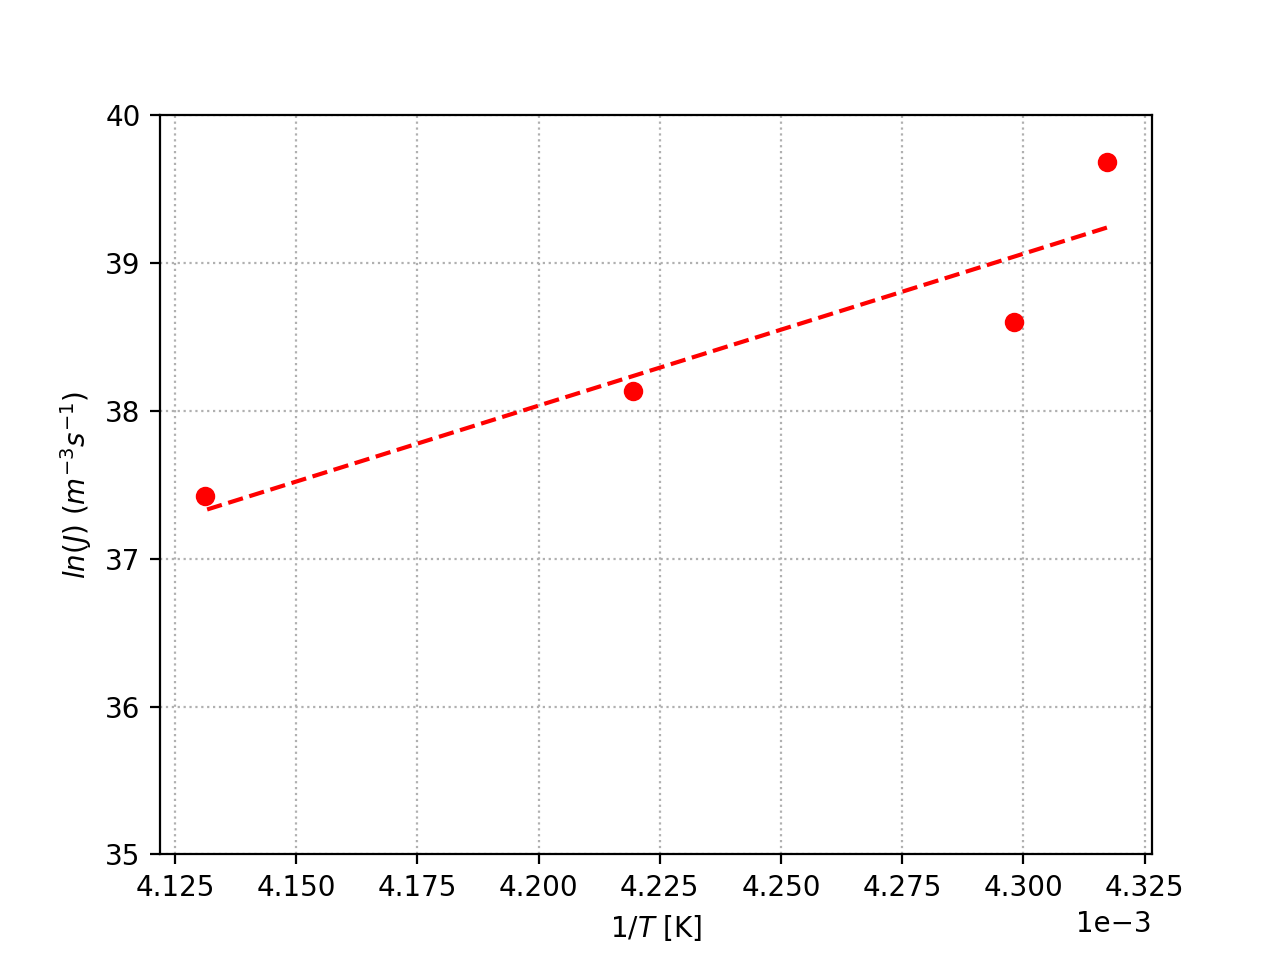

In [135]:

fig = plt.figure()
m,b = slope_and_intercept(new_T, new_J)
line_fit = np.array([(m*x)+b for x in new_T])
plt.plot(new_T, new_J, 'ro')
plt.plot(new_T, line_fit, 'r--')
plt.xlabel('$1/T$ [K]')
plt.ylabel('$ln(J)\ (m^{-3}s^{-1})$')
#plt.legend(loc='upper right',fontsize=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(35,40)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')
plt.show()

In [136]:
J_0 = np.exp(b)
den_t = np.array(T)[idx]

In [137]:
#Temperature dependent densities 

data = np.loadtxt('/Users/niloo/Desktop/SwissFel_2019/data_beamtime/specific_volume.dat')
T_data = []
rho_data = []
for i in range(len(data)):
    rho_data.append(data[i][1])
    T_data.append(data[i][0])
T_arr = np.array(T_data)
rho_arr = np.array(rho_data)
f_rho = interp1d(T_arr, rho_arr)

# density extrapolation from Kell et al
N_A = 6.0221367e23 # molecules/mol
m_h2o = 2*1.00794+15.9995 # g/mol
# ALGORITHM 1 -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
rho_si = (933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (den_t - 233.0573)))) / 1000 # g/cm^3
rho = rho_si*N_A/1e24/m_h2o # molecules/A^3

<IPython.core.display.Javascript object>


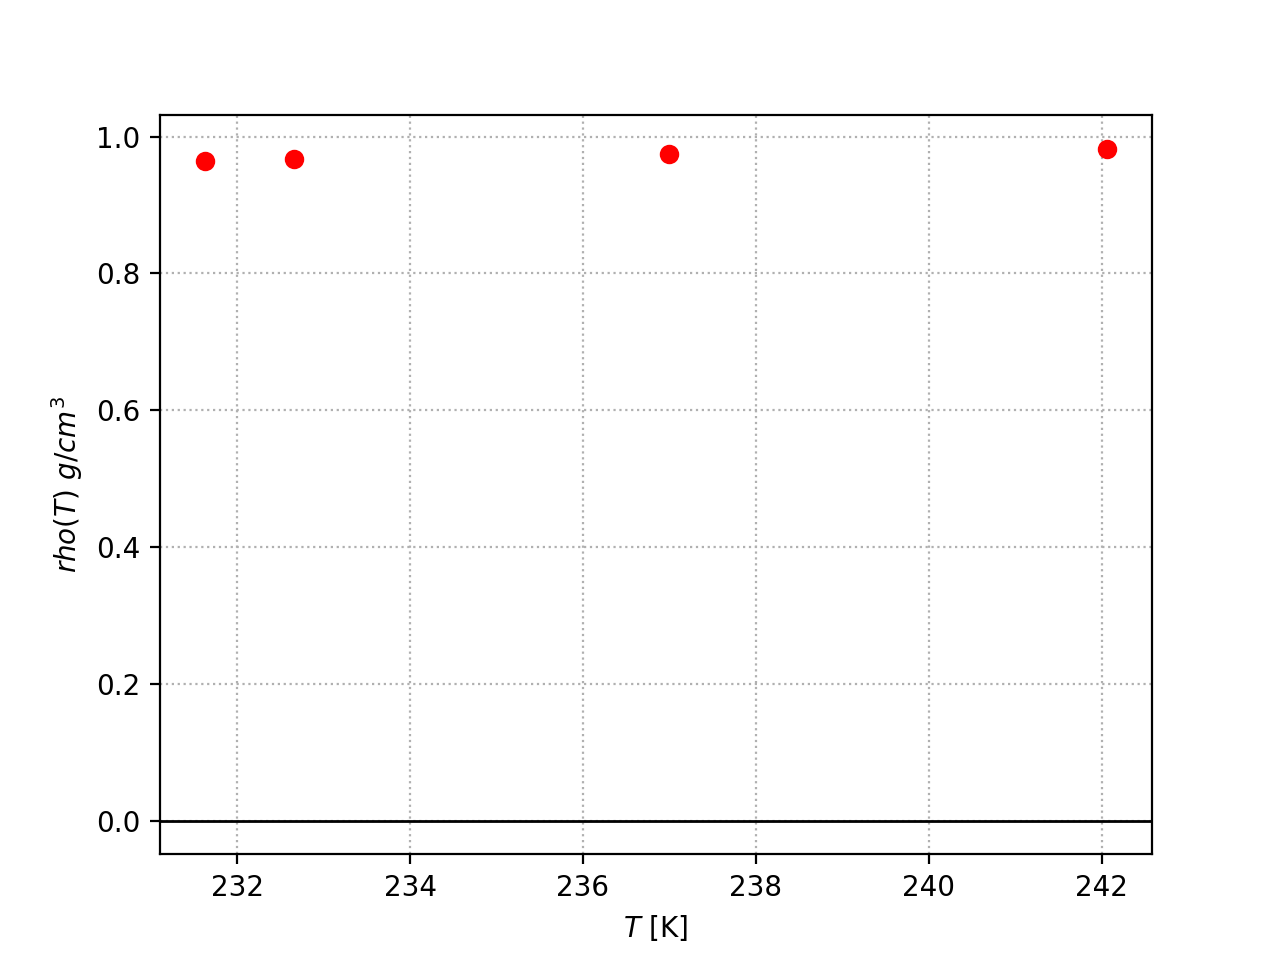

In [198]:
fig = plt.figure()
plt.plot(den_t, rho_si, 'ro')
#plt.plot(T_arr+273, rho_arr)
plt.xlabel('$T$ [K]')
plt.ylabel('$rho(T)\ g/cm^3$')
plt.axhline(0,c='black',lw=1)
#plt.ylim(0.9,1.)
plt.grid(linestyle='dotted')
plt.show()

In [240]:
# Ice molar volume
molar_mass = 18.01528 #g/mol
ice_vol = molar_mass/rho_si #cm^3/mol
# convert to m^3/mol
#ice_vol = ice_vol*10**-6
ice_vol = (10**-30)*N_A/rho # m^3/mol 

In [241]:
# make fit for D_s from SwissFEL to lab T 
D_data = np.loadtxt('/Users/niloo/Desktop/Lab_data/altogether/diffusion/ver3/entropy_data_7.2.csv', delimiter=',')


T_s = np.array([D_data[i,0] for i in range(len(D_data))])
D_s = np.array([D_data[i,13] for i in range(len(D_data))])
Inv_T = 1./T_s
fit_D = interpolate.InterpolatedUnivariateSpline(Inv_T, D_s)
D = fit_D(new_T)
# Boltzmann constant : 1.380649 × 10−23 joule per kelvin
K = 1.380649e-23 # joule per kelvin

<IPython.core.display.Javascript object>


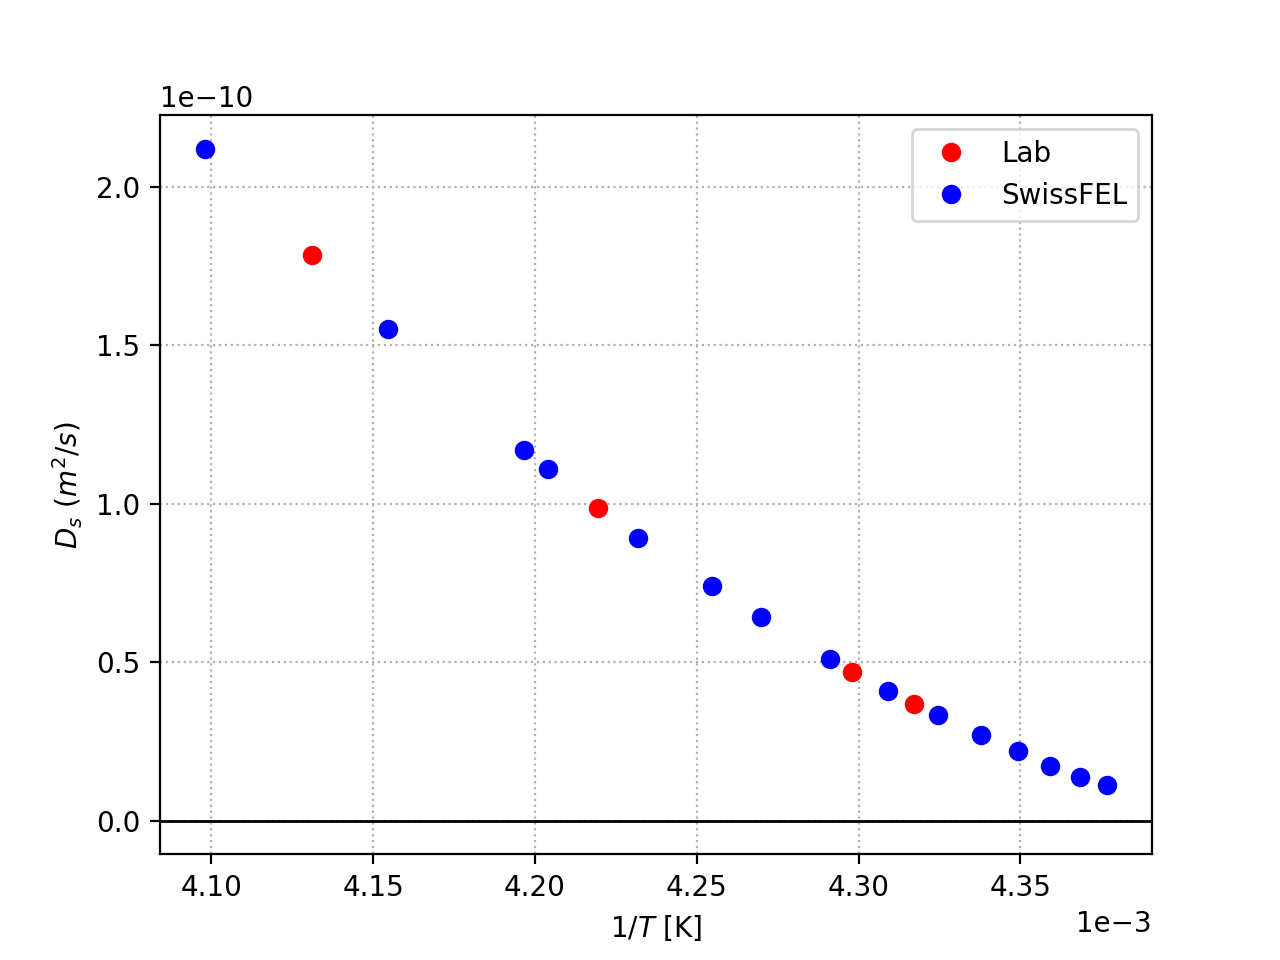

In [242]:
fig = plt.figure()
plt.plot(new_T, D, 'ro', label = 'Lab')
plt.plot(Inv_T, D_s, 'bo', label = 'SwissFEL')
plt.xlabel('$1/T$ [K]')
plt.ylabel('$D_s\ (m^2/s)$')
plt.axhline(0,c='black',lw=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.show()

In [243]:
sigma = K*den_t*((J_0/16.)*((4./(3.*np.pi))**(1./3.))*((ice_vol)**(4./3.))/D)**2 # Joule/m^2

<IPython.core.display.Javascript object>


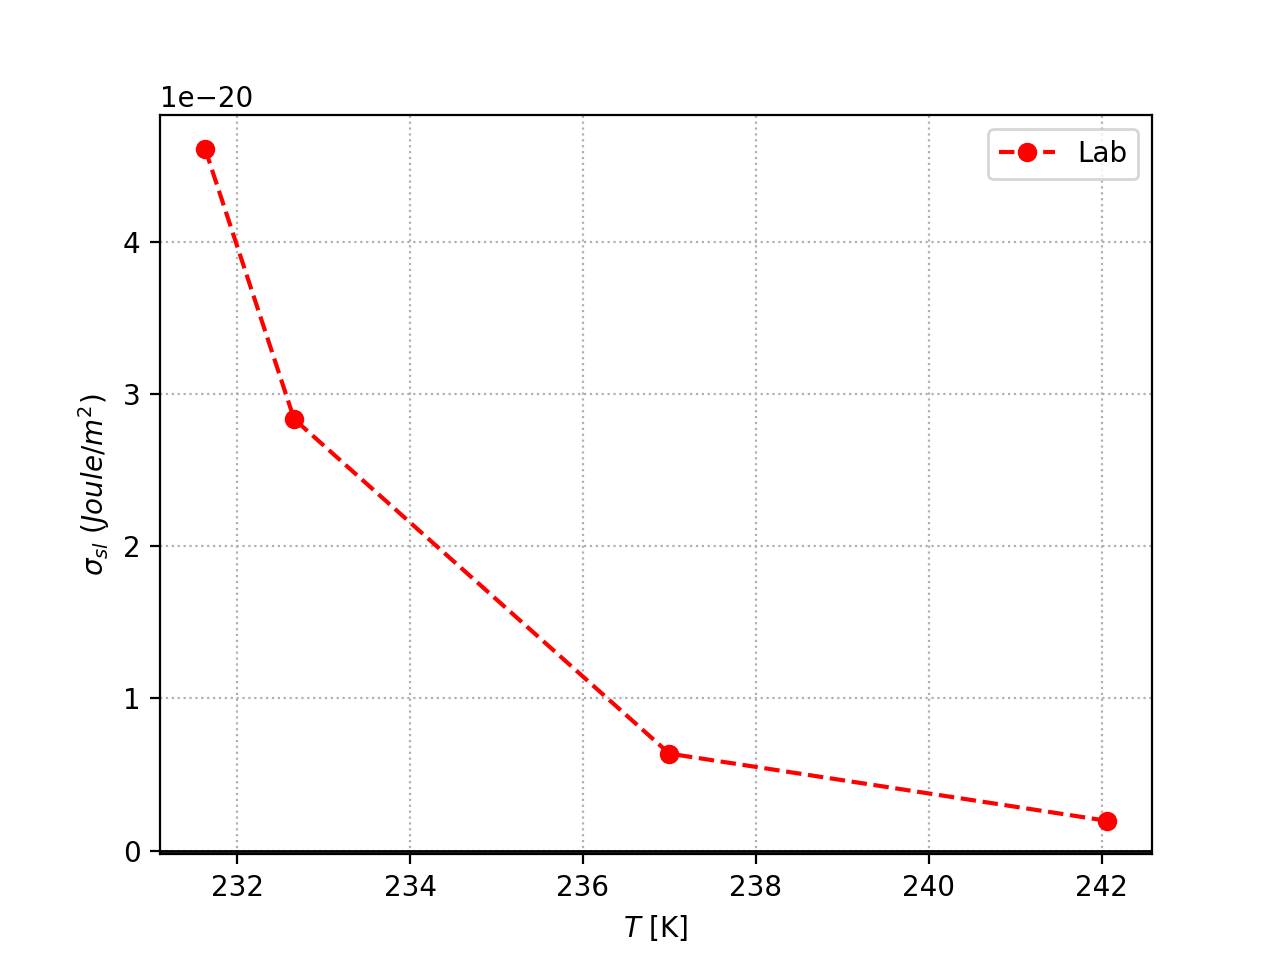

In [244]:
fig = plt.figure()
plt.plot(den_t, sigma, 'ro--', label = 'Lab')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma_{sl}\ (Joule/m^2)$')
plt.axhline(0,c='black',lw=1)
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.show()

In [255]:
laksmono_T = np.array([252.23,237.36,232.03,228.81,227.58,226.57])
laksmono_T = np.array(sorted(laksmono_T))
sig_lak = (20.8*(laksmono_T/235.8)**0.67)/1000
sig_lab = (20.8*(den_t/235.8)**0.67)/1000

<IPython.core.display.Javascript object>


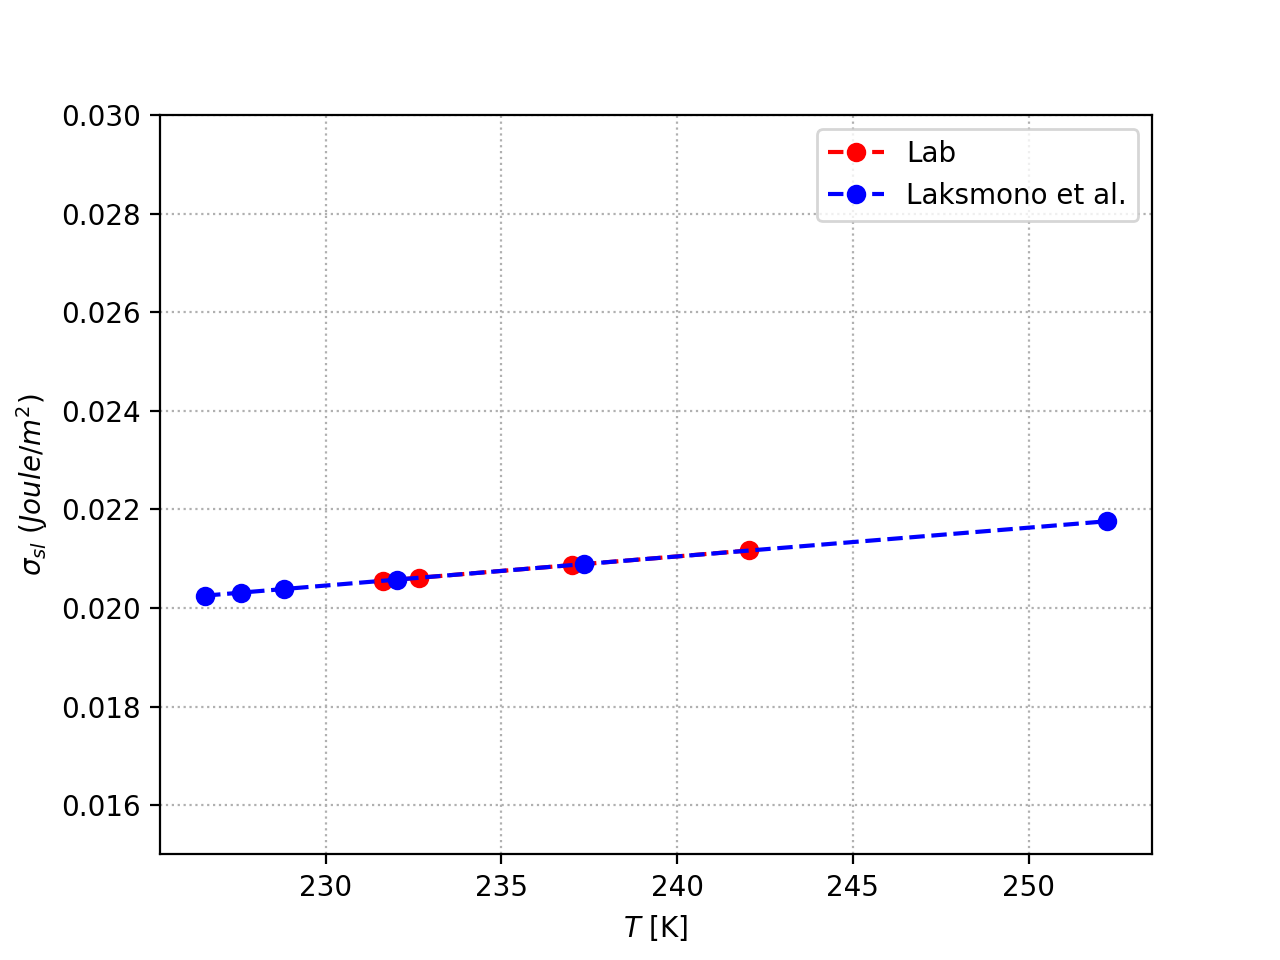

In [259]:
fig = plt.figure()
plt.plot(den_t, sig_lab, 'ro--', label = 'Lab')
plt.plot(laksmono_T, sig_lak, 'bo--', label = 'Laksmono et al.')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma_{sl}\ (Joule/m^2)$')
plt.axhline(0,c='black',lw=1)
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.ylim(0.015, 0.03)
plt.show()